### Import necessary libraries

In [34]:
%matplotlib inline
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

### Load data

In [35]:
# Please replace the path pointed to a file location on your computer
df = pd.read_csv('C:/Users/nvduy/DS/listings.csv',low_memory=False, na_values=['',' ','N/A'], parse_dates=True)

In [36]:
# Inspect the dataframe loaded
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20190808195507,2019-08-09,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.12
1,20168,https://www.airbnb.com/rooms/20168,20190808195507,2019-08-09,Studio with private bathroom in the centre 1,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,2.46
2,25428,https://www.airbnb.com/rooms/25428,20190808195507,2019-08-09,Lovely apt in City Centre (w.lift) near Jordaan,NaN,"This nicely furnished, newly renovated apt is...","This nicely furnished, newly renovated apt is...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.16
3,27886,https://www.airbnb.com/rooms/27886,20190808195507,2019-08-09,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,For a romantic couple: A beautifully restored ...,Stylish and romantic houseboat on fantastic hi...,none,"Central, quiet, safe, clean and beautiful.",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.11
4,28871,https://www.airbnb.com/rooms/28871,20190808195507,2019-08-09,Comfortable double room,NaN,In a monumental house right in the center of A...,In a monumental house right in the center of A...,none,NaN,...,f,f,moderate,f,f,3,0,3,0,2.59


Drop columns with no variation or useful data for predicting price and availability (such as dates, URL, id, name, descriptions...)

In [37]:
# Furthermore, I will use quantified review score in place of review's comments so I also drop those comments
df = df.drop(['calendar_last_scraped','first_review','last_review','host_verifications','host_since','listing_url','scrape_id','last_scraped','name','summary','space','description','experiences_offered','neighborhood_overview','notes','transit','access','interaction','house_rules','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url','host_name','host_about','host_acceptance_rate','host_thumbnail_url','host_picture_url','host_location','neighbourhood_group_cleansed','country','license','jurisdiction_names','requires_license','country_code','city','state','amenities'],axis=1)

In [38]:
# Similarly, I will drop locations related columns as keep only latitude and longitude to represent the locations
df = df.drop(['host_neighbourhood','street','zipcode','smart_location','market','neighbourhood_cleansed'], axis=1)

In [39]:
# Convert percentage columns to float
df['host_response_rate'] = df['host_response_rate'].str.replace(r'%', r'.0').astype('float')/100

In [40]:
# Convert $ dollar sign columns to float
df['price'] = df['price'].replace({'\$':'', ',':''}, regex=True).astype('float')
df['security_deposit'] = df['security_deposit'].replace({'\$':'', ',':''}, regex=True).astype('float')
df['cleaning_fee'] = df['cleaning_fee'].replace({'\$':'', ',':''}, regex=True).astype('float')
df['extra_people'] = df['extra_people'].replace({'\$':'', ',':''}, regex=True).astype('float')

In [41]:
# Convert object type to category
for c in df.columns[df.dtypes == object]: # df.dtypes == 'object'
    df[c] = df[c].astype('category')

In [42]:
# Check data again
pd.options.display.max_rows=75
df.isnull().sum()

id                                                  0
host_response_time                               8541
host_response_rate                               8541
host_is_superhost                                  12
host_listings_count                                12
host_total_listings_count                          12
host_has_profile_pic                               12
host_identity_verified                             12
neighbourhood                                     831
latitude                                            0
longitude                                           0
is_location_exact                                   0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                                           6
bedrooms                                            8
beds                                                8
bed_type                    

### Dealing with missing data

In [43]:
# I will again drop those columns that missing too many rows or not appropriate to impute such as name/location or date
df = df.drop(['host_response_time','square_feet','weekly_price','monthly_price'],axis=1)

In [44]:
# I will fill-in value 0 for these columns
df['security_deposit'].fillna(0, inplace=True)
df['cleaning_fee'].fillna(0, inplace=True)
df['reviews_per_month'].fillna(0, inplace=True)

In [45]:
# I will fill-in mean values for those columns 
df['host_response_rate'].fillna(df['host_response_rate'].mean(), inplace=True)
df['review_scores_rating'].fillna(df['review_scores_rating'].mean(), inplace=True)
df['review_scores_accuracy'].fillna(df['review_scores_accuracy'].mean(), inplace=True)
df['review_scores_cleanliness'].fillna(df['review_scores_cleanliness'].mean(), inplace=True)
df['review_scores_checkin'].fillna(df['review_scores_checkin'].mean(), inplace=True)
df['review_scores_communication'].fillna(df['review_scores_communication'].mean(), inplace=True)
df['review_scores_location'].fillna(df['review_scores_location'].mean(), inplace=True)
df['review_scores_value'].fillna(df['review_scores_value'].mean(), inplace=True)

In [46]:
# Finally, for the columns with missing only a few rows, I will drop these rows
df.dropna(inplace=True, axis=0)

In [47]:
# Check the final shape of the dataframe
df.shape

(19814, 56)

In [48]:
df.describe()

,id,host_response_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.981400e+04,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000,...,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000,19814.000000
mean,1.782568e+07,0.935897,7.211113,7.211113,52.366448,4.885612,2.858232,1.152165,1.436964,1.799233,...,9.470111,9.734204,9.788788,9.489222,9.175635,5.047088,4.630060,0.395377,0.021651,0.859209
std,1.041779e+07,0.128623,38.470214,38.470214,0.014778,0.030708,1.285021,0.371417,0.871690,1.363136,...,0.807013,0.612240,0.570556,0.649728,0.751247,23.301689,23.125145,1.052180,0.240681,1.298809
min,2.818000e+03,0.000000,0.000000,0.000000,52.321590,4.753120,1.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9.234532e+06,0.936235,1.000000,1.000000,52.355832,4.862753,2.000000,1.000000,1.000000,1.000000,...,9.000000,9.735762,9.789488,9.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.140000
50%,1.760622e+07,0.936235,1.000000,1.000000,52.365280,4.885250,2.000000,1.000000,1.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.430000
75%,2.592698e+07,1.000000,2.000000,2.000000,52.375560,4.905630,4.000000,1.000000,2.000000,2.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.000000,0.990000
max,3.758653e+07,1.000000,980.000000,980.000000,52.424710,4.980150,30.000000,15.000000,12.000000,32.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,208.000000,206.000000,15.000000,8.000000,33.670000


### Exploratory Data Analysis (EDA)

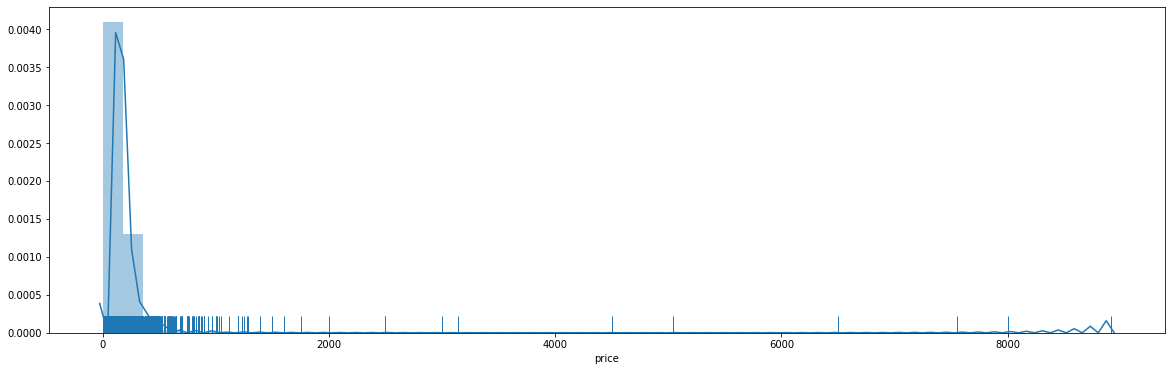

In [49]:
# Chechk the distribution of target variable price
plt.figure(figsize=(20,6))
sb.distplot(df['price'], rug=True)

We see that the distribution of price is extremely right_skewed, there are a few outliers with price can reach as high as $8,000. The majority of the price would be less than $1,000. To make sure these outliers will not affect the prediction power, I will limit the price range below $1,000

In [50]:
# Trim the right tail
df = df[df['price']<1000]
df.shape

(19771, 56)

After trimming the right tail, the dataset won't affect much, we go from 19814 down to 19771 observation.

In [51]:
# Let's see the type of room available
df['room_type'].unique()

[Private room, Entire home/apt, Shared room]
Categories (3, object): [Private room, Entire home/apt, Shared room]

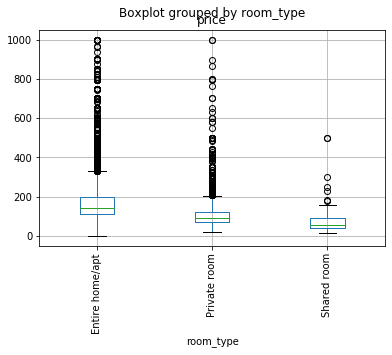

In [52]:
# How the distribution of price according to room type
df.boxplot(column='price', by='room_type', rot=90)

It is reasonable that an entire house is more expensive than a shared room

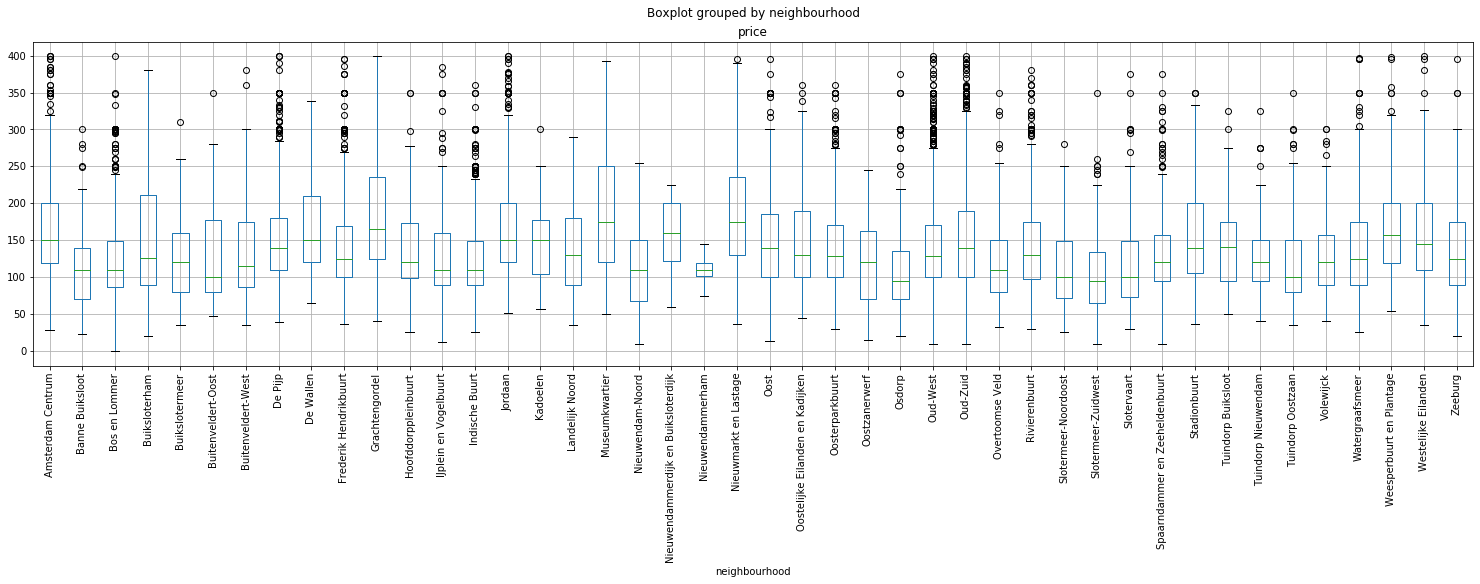

In [53]:
# Let's see which neighborhood tend to cost more than the others without extreme values
df[df['price']<400].boxplot(column='price', by='neighbourhood', figsize=(25,6), rot=90)

Most neighborhoods are priced similarly with the boxplots tend to overlap each other. Moreover, the neighborhood group in the middle from Kadoelen to Nieuwendammerham is affordably priced without extreme rent.

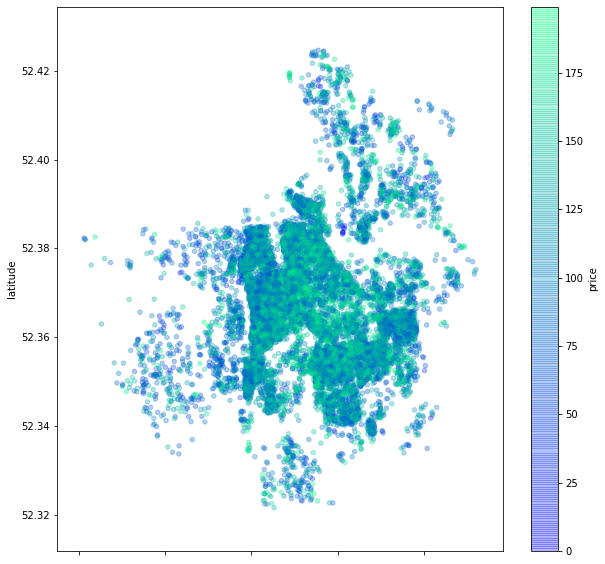

In [54]:
# As the 75 percentile of the price is $180, let's see the price per location without extreme values
df[df['price']<200].plot.scatter(x='longitude', y='latitude', c='price', figsize=(10,10), cmap='winter', alpha=0.3)

As in the case of price vs neighborhood boxplot above, the distribution of price are spaced evenly across the area for the price range under $1,000

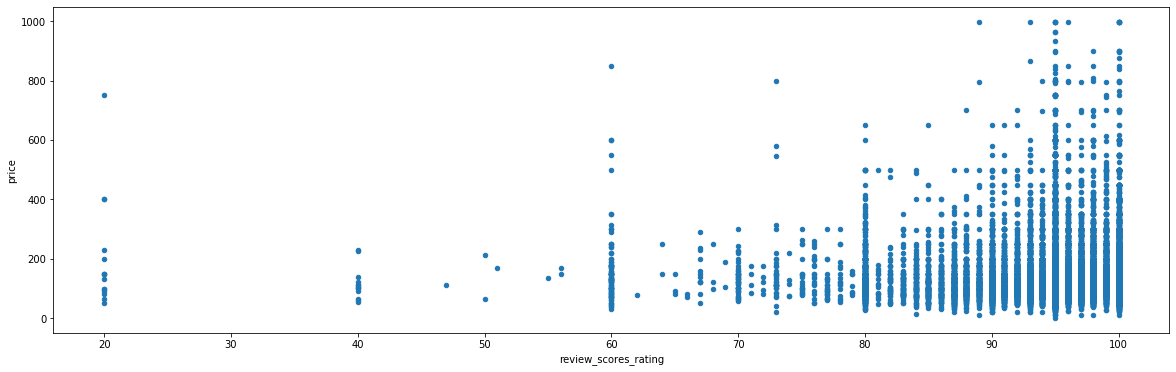

In [55]:
# How about the relationship between 'price' and 'review_rating'
df.plot.scatter(x='review_scores_rating', y='price', figsize=(20,6))

For more expensive rent, there are seemingly more ratings with a wider range of ratings. The distribution of rating fall in the range of 60 and above. Especially, some cheap rent (bottom left bundle) is associated with a low review score rating of 20

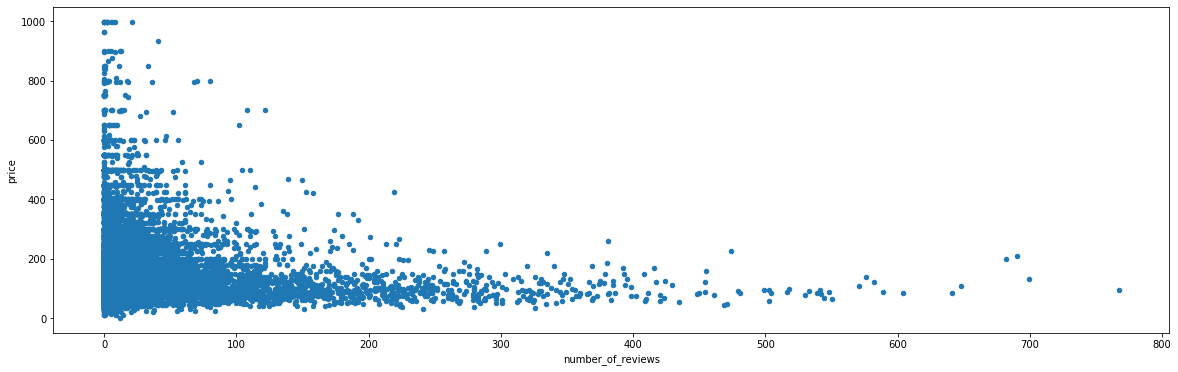

In [56]:
# Let's see the number of reviews vs price
df.plot.scatter(x='number_of_reviews', y='price', figsize=(20,6))

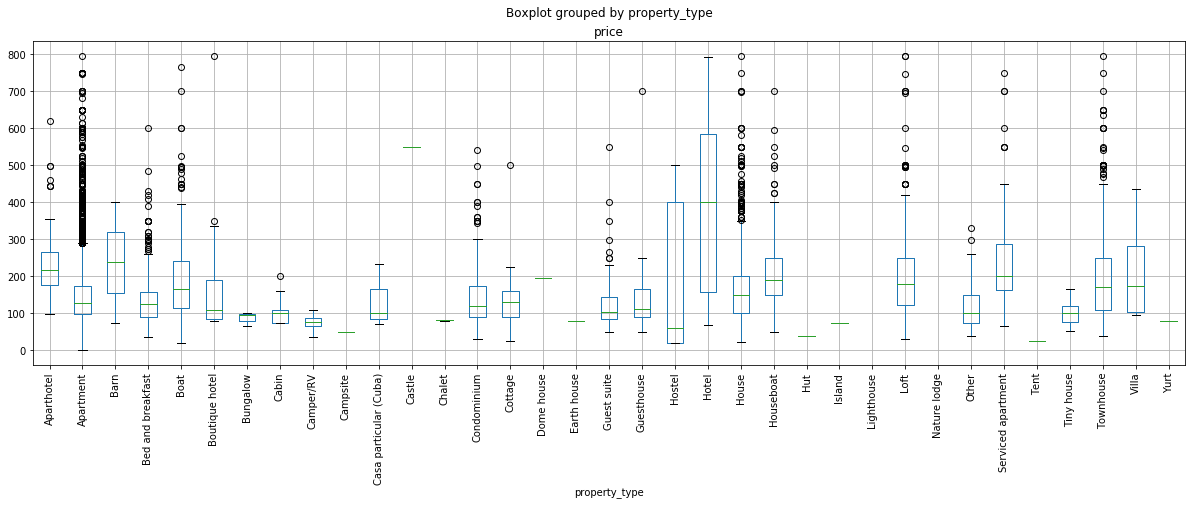

In [57]:
# How about 'property_type' vs 'price'
df[df['price']<800].boxplot(column='price', by='property_type', figsize=(20,6), rot=90)

Hotel and hostel priced vastly different while apartment and house tend to have more extreme rent compared to the same group

### Create the dataset for supervise learning

In [58]:
# Dummify the categorical variables
data = pd.get_dummies(df)

In [59]:
data.head()

,id,host_response_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
0,2818,1.0,1.0,1.0,52.36575,4.94142,2,1.5,1.0,2.0,...,1,0,0,1,0,0,1,0,1,0
1,20168,1.0,2.0,2.0,52.36509,4.89354,2,1.0,1.0,1.0,...,1,0,0,1,0,0,1,0,1,0
2,25428,1.0,2.0,2.0,52.37297,4.88339,3,1.0,1.0,1.0,...,1,0,0,1,0,0,1,0,1,0
3,27886,1.0,1.0,1.0,52.38673,4.89208,2,1.0,1.0,1.0,...,1,0,0,1,0,0,1,0,1,0
4,28871,1.0,3.0,3.0,52.36719,4.89092,2,1.0,1.0,1.0,...,1,0,1,0,0,0,1,0,1,0


In [60]:
# Create target variable
X = data.copy().drop('price', axis=1)
y = data['price'].copy()

In [61]:
# Create training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [62]:
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Regression-Tree in scikit-learn

In [63]:
# Instantiate a Decision Tree Regressor 'dt'
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1)

In [64]:
# Fit 'dt' to the training-set
dt.fit(X_train_scaled, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [65]:
# Predict test-set labels
y_pred = dt.predict(X_test_scaled)

In [66]:
# Compute test-set MSE
mse_dt = MSE(y_test, y_pred)
print(mse_dt)

6209.721150911738


In [67]:
# Compute test-set RMSE
rmse_dt = mse_dt**(1/2)

In [68]:
# Print rmse_dt
print(rmse_dt)

78.80178393229266


### K-Fold CV with Regression Tree

In [69]:
# Evaluate the list of MSE ontained by 10-fold CV
MSE_CV = - cross_val_score(dt, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

In [70]:
# Fit 'dt' to the training set
dt.fit(X_train, y_train)

# Predict the labels of training set
y_predict_train = dt.predict(X_train)

# Predict the labesl of test set
y_predict_test = dt.predict(X_test)

# CV MSE
print('CV MSE: {:.2f}'.format(MSE_CV.mean()))

CV MSE: 6539.53


In [71]:
# Training set MSE
print('Train MSE: {:.2f}'.format(MSE(y_train, y_predict_train)))

Train MSE: 6470.62


In [72]:
# Test set MSE
print('Test MSE: {:.2f}'.format(MSE(y_test, y_predict_test)))

Test MSE: 6209.72


Cross-validation errors are about the same as training set error indicate that the model does not suffer from high variance. Let's compare the model with other methods later see which one is more bias. Unlike other methods, Decision Tree works well and error is similar to the scaled or unscaled version of the data. I have the same prediction error for both scaled and unscaled version of the data but the scaled one make the model run faster so I will continue using the scaled version in later models.

### Supervise Learning with Linear Regression, Ridge, Lasso and ElasticNet

In [73]:
# Instantiate individual regressor
lr = LinearRegression()
alphas = [1000, 100, 50, 20, 10, 1, 0.1, 0.01]
l1_ratios = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
ridge = RidgeCV(alphas=alphas)
lasso = LassoCV(alphas=alphas, max_iter=10000)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)

In [74]:
# Create a list of tuples of regressors
regressors = [('Linear Regression', lr), ('Ridge Regression', ridge), ('Lasso Regression', lasso), ('Elastic Net', elastic)]

In [75]:
# Iterate over the defined list of tuples containing the regressors
warnings.filterwarnings('ignore')
for rg_name, rg in regressors:
    # fit rg to the training set
    rg.fit(X_train_scaled, y_train)
    
    # Predict the labels of the test set
    y_pred = rg.predict(X_test_scaled)
    
    # Evaluate the error of regressors on the test set
    best_alpha=''
    best_l1=''
    if rg_name == 'Linear Regression':
        print('{:s} : {:.3f}'.format(rg_name, MSE(y_test, y_pred)))
    if rg_name != 'Linear Regression':
        best_alpha = ' best_alpha: ' + str(rg.alpha_)
        print('{:s} : {:.3f}'.format(rg_name, MSE(y_test, y_pred)) + best_alpha)
    if rg_name == 'Elastic Net':
        best_l1 = ' best l1: ' + str(rg.l1_ratio_)
        print('{:s} : {:.3f}'.format(rg_name, MSE(y_test, y_pred)) + best_l1)

Linear Regression : 826969998034919597195395072.000
Ridge Regression : 4067.256 best_alpha: 20.0
Lasso Regression : 4054.955 best_alpha: 0.1
Elastic Net : 4053.598 best_alpha: 0.1
Elastic Net : 4053.598 best l1: 0.9


We can see that Linear Regression is the worst with error out of the roof. With scaled data, Elastic Net performs the best but not much far away from Ridge and Lasso Regression. Besides, Elastic Net predict 'price' better than the Regression Tree baseline model above with the prediction error of 6209

In [76]:
# Instantiate a VotingRegressor 'vr'
vr = VotingRegressor(estimators=regressors)

# Fit 'vr' to the training set and predict test set labels
vr.fit(X_train_scaled, y_train)
y_pred = vr.predict(X_test_scaled)

# Evaluate the test-set error of 'vr'
print('Voting Regressor: {:.3f}'.format(MSE(y_test, y_pred)))

Voting Regressor: 51685624877188255850692608.000


In this dataset, the ensemble of different regressors did not predict well as a single Elastic Net method. Given that a single Decision Tree was outperformed by Elastics Net. I will test Bagging with Decision Tree to see how its stack up. However, before doing that, let's see which features are important in predicting 'price' from Lasso regression.

In [77]:
# Non-zero Lasso coefficients ordered by importance
order = np.argsort(np.abs(lasso.coef_))[::-1]
for i in order:
    coef_ = lasso.coef_[i]
    if coef_ > 0:
        print(X.columns[i] + ', ' + str(lasso.coef_[i]))

accommodates, 25.210297940985463
minimum_maximum_nights, 21.865577132378245
bedrooms, 17.85500097206173
room_type_Entire home/apt, 13.252410484980015
neighbourhood_Grachtengordel, 11.637399851645354
host_listings_count, 11.47508546345068
neighbourhood_Amsterdam Centrum, 10.650378215636644
neighbourhood_Jordaan, 9.622690120582156
bathrooms, 9.022388471518395
property_type_Hostel, 7.490020427158921
availability_30, 7.38452992633418
availability_365, 7.180314759722623
availability_90, 6.710933086037754
property_type_Hotel, 6.3238611474865625
cancellation_policy_super_strict_60, 6.086342629141643
neighbourhood_Oud-Zuid, 5.988956846786532
id, 5.852699795399989
neighbourhood_De Wallen, 5.678237405374202
cleaning_fee, 5.346736964358729
longitude, 5.088246641279367
neighbourhood_Nieuwmarkt en Lastage, 4.702396433500883
review_scores_rating, 4.608718286681074
neighbourhood_Oud-West, 4.487991293450712
neighbourhood_Westelijke Eilanden, 4.139877011560947
neighbourhood_Museumkwartier, 3.8679356515

As we can see from this list, the top ten most important features to change 'price' are: 
accommodates, minimum_maximum_nights, bedrooms, room_type_Entire home/apt, neighbourhood_Grachtengordel, neighbourhood_Amsterdam Centrum, host_listings_count, neighbourhood_Jordaan, bathrooms, and property_type_Hotel

As with real estate rent, 3 broad groups influence the price. First, the location such as a neighborhood. Second, the type of property such as room_type, property_type, bedrooms, bathrooms. And, third, the number of stays like accommodates and nights are good predictors of 'price

### Bagging with Decision Tree Regressor

In [78]:
# Instantiate a BaggingRegressor 'br'
br = BaggingRegressor(base_estimator=dt, n_estimators=300, oob_score=True, n_jobs=-1)

In [79]:
# Fit, predict and evaluate the error
br.fit(X_train_scaled, y_train)
y_pred = br.predict(X_test_scaled)
test_MSE = MSE(y_test, y_pred)
oob_MSE = br.oob_score_
print('Test MSE: {:.2f}'.format(test_MSE))
print('Out of Bag MSE: {:.2f}'.format(oob_MSE))

Test MSE: 6348.21
Out of Bag MSE: 0.27


As in the case of the ensemble above, bagging of Decision Trees won't help to reduce the error. Let's check another type of ensembling of trees which is Random Forest

### Random Forest Regressor

In [85]:
# Instantiate a random forests regressor 'rf' 300 estimators 
rf = RandomForestRegressor(n_estimators=500, max_depth=6, min_samples_leaf=0.1)

# Fit, predict and evaluate the error
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
print('Test MSE: {:.2f}'.format(MSE(y_test, y_pred)))

Test MSE: 6346.65


Similarly, with other ensemble methods, the Random Forest can't compete with Ridge, Lasso and Elastic Net Regression above. How about feature importance selected by Random Forest, will it be much different from Lasso. Let's check it out

### Feature Importance with Random Forest

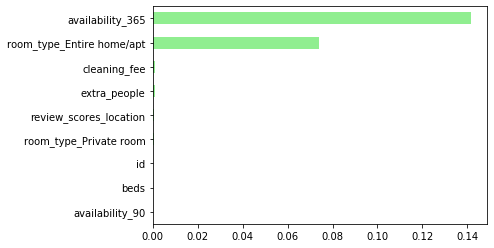

In [81]:
# Create a pd.Series of features importances 
importances_rf = pd.Series(rf.feature_importances_, index = X.columns) 
 
# Sort importances_rf                                    
sorted_importances_rf = importances_rf.sort_values()[-10:-1]    
 
# Make a horizontal bar plot 
sorted_importances_rf.plot(kind='barh', color='lightgreen'); plt.show() 

The ensemble methods agree with Lasso on the property type such as room type, beds and the location of the place like reviews_location and longitude that help predict 'price'. 

It is reasonable that the availability also closely relates to price as it predicts how busy a host's place is. 

Let's fine-tune the hyperparameters of this Random Forest to see if we can do better

### Fine tune Random Forest hyperparameters

In [82]:
# Define a grid of hyperparameter 'params_rf' 
params_rf = { 'n_estimators': [300, 400, 500], 'max_depth': [4, 6, 8], 'min_samples_leaf': [0.1, 0.2], 'max_features': ['log2', 'sqrt']} 

# Instantiate 'grid_rf' 
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf,  cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1) 

In [83]:
# Fit 'grid_rf' to the training set 
grid_rf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=0.1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=300, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8],
          

In [84]:
# Extract best hyperparameters from 'grid_rf' 
best_hyperparams = grid_rf.best_params_ 
 
print('Best hyerparameters:\n', best_hyperparams) 

Best hyerparameters:
 {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'n_estimators': 500}


The hyperparameters I am using so far already the best ones so there is no need to change or improve Random Forest further.

Let's try one last ensemble method which often performs well for various machine learning tasks.

### Gradient Boosting and Feature Selection

In [88]:
# Instantiate a GradientBoostingRegressor 'gbt' 
gbt = GradientBoostingRegressor(n_estimators=300, max_depth=1) 

# Fit 'gbt' to the training set 
gbt.fit(X_train_scaled, y_train) 

# Predict the test set labels 
y_pred = gbt.predict(X_test_scaled) 

# Print the test set RMSE 
print('Test set MSE: {:.2f}'.format(MSE(y_test, y_pred)))
print('Test set RMSE: {:.2f}'.format(np.sqrt(MSE(y_test, y_pred))))

Test set MSE: 3918.01
Test set RMSE: 62.59


Finally, this ensemble method can beat the Elastic Net method above with a test MSE of 4053. Let's check out features importances selected by Gradient Boosting

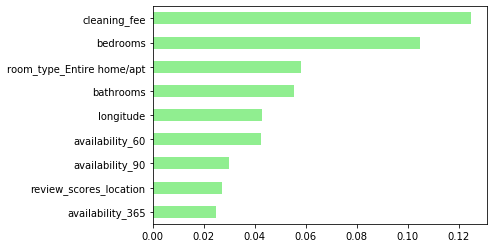

In [89]:
# Create a pd.Series of features importances 
importances_gbt = pd.Series(gbt.feature_importances_, index = X.columns) 
 
# Sort importances_rf                                    
sorted_importances_gbt = importances_gbt.sort_values()[-10:-1]    
 
# Make a horizontal bar plot 
sorted_importances_gbt.plot(kind='barh', color='lightgreen'); plt.show() 

Gradient Boosting agrees with Random Forest in terms of which features to look for such as property type and the location of Airbnb. The differences are now the rules like cleaning_fee and cancellation policy also should be taken note of.

In summary, we could use Gradient Boosting for price prediction but still pay close attention to both features selected by Lasso and this ensemble method to determine the 'correct' price for an Airbnb place.

For houses that can be rent for under $1,000, Gradient Boosting or Elastic NetCV can predict a price with error in the range of $62.59. This range of error can be reduced further by going back to the first step and removing more unnecessary variables that highly correlated with the ones already in the dataset. Or I can try PCA before feeding into the prediction model but then the important features will not be observed then.